Model Building, Training & Performance Profiling

✅ Data Loading Complete.

🚀 Modeling E-commerce Fraud (SMOTE Balanced)

--- LogisticRegression on E-commerce Fraud ---
CV PR-AUC: 0.9069 ± 0.0011
Train vs Test PR-AUC: 0.9066 / 0.6445 (Gap: 0.2621)
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27393
           1       0.52      0.70      0.60      2830

    accuracy                           0.91     30223
   macro avg       0.75      0.82      0.77     30223
weighted avg       0.93      0.91      0.92     30223

Confusion Matrix (Test):
[[25578  1815]
 [  846  1984]]


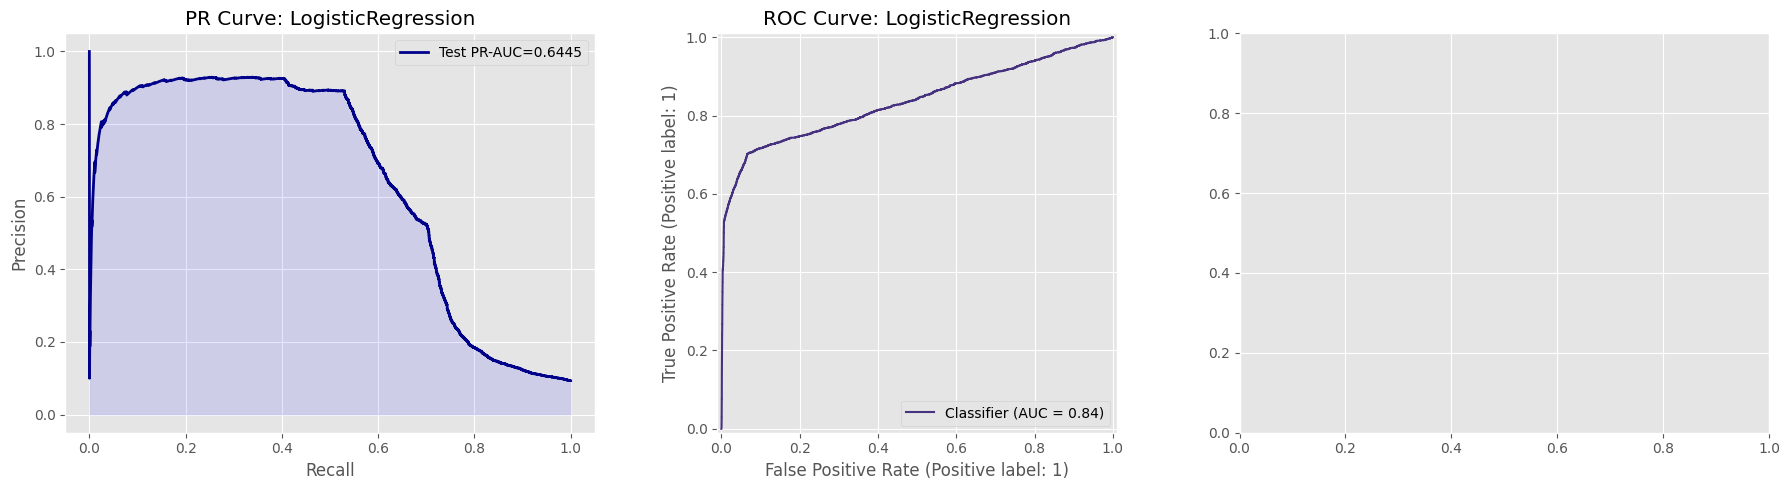


--- RandomForestClassifier on E-commerce Fraud ---
CV PR-AUC: 0.9681 ± 0.0002
Train vs Test PR-AUC: 0.9678 / 0.7060 (Gap: 0.2618)
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     27393
           1       0.58      0.67      0.62      2830

    accuracy                           0.92     30223
   macro avg       0.77      0.81      0.79     30223
weighted avg       0.93      0.92      0.93     30223

Confusion Matrix (Test):
[[26016  1377]
 [  923  1907]]


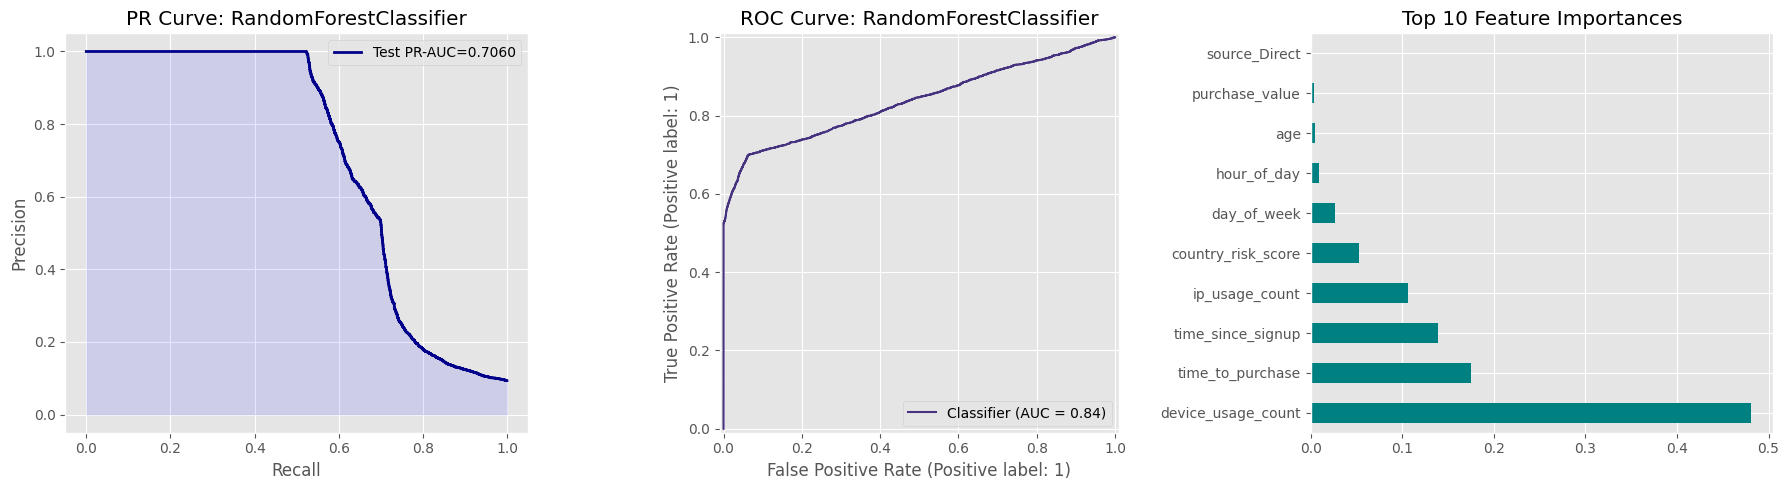

In [2]:
# ========================================================
# Task 2: Model Building, Training & Performance Profiling
# ========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix, RocCurveDisplay, RocCurveDisplay

# -----------------------------
# Professional Plotting Setup
# -----------------------------
plt.style.use('ggplot')
sns.set_palette("viridis")

# --------------------------------------------------------
# 1️⃣ Load All Processed Data
# --------------------------------------------------------
# E-commerce Fraud
X_train_f = pd.read_csv("../data/processed/fraud_X_train.csv")
y_train_f = pd.read_csv("../data/processed/fraud_y_train.csv").values.ravel()
X_test_f = pd.read_csv("../data/processed/fraud_X_test.csv")
y_test_f = pd.read_csv("../data/processed/fraud_y_test.csv").values.ravel()

# Bank Credit Card
X_train_c = pd.read_csv("../data/processed/credit_X_train.csv")
y_train_c = pd.read_csv("../data/processed/credit_y_train.csv").values.ravel()
X_test_c = pd.read_csv("../data/processed/credit_X_test.csv")
y_test_c = pd.read_csv("../data/processed/credit_y_test.csv").values.ravel()

print("✅ Data Loading Complete.")

# --------------------------------------------------------
# 2️⃣ Master Evaluation Function
# --------------------------------------------------------
def run_evaluation(model, X_train, y_train, X_test, y_test, dataset_name):
    """
    Evaluates model stability (CV), performance (PR-AUC, ROC-AUC), 
    and generalization (Train vs Test), including confusion matrix and feature importance.
    """
    model_name = model.__class__.__name__
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # -----------------------------
    # 1. Cross-Validation (PR-AUC)
    # -----------------------------
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='average_precision')
    
    # -----------------------------
    # 2. Fit and Predict
    # -----------------------------
    model.fit(X_train, y_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_test_pred = model.predict(X_test)
    
    # -----------------------------
    # 3. Metrics
    # -----------------------------
    # PR-AUC
    p_train, r_train, _ = precision_recall_curve(y_train, y_train_prob)
    p_test, r_test, _ = precision_recall_curve(y_test, y_test_prob)
    auc_train, auc_test = auc(r_train, p_train), auc(r_test, p_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    print(f"\n--- {model_name} on {dataset_name} ---")
    print(f"CV PR-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Train vs Test PR-AUC: {auc_train:.4f} / {auc_test:.4f} (Gap: {auc_train-auc_test:.4f})")
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))
    print("Confusion Matrix (Test):")
    print(cm)
    
    # -----------------------------
    # 4. Visualizations
    # -----------------------------
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # PR Curve
    axes[0].plot(r_test, p_test, label=f'Test PR-AUC={auc_test:.4f}', color='darkblue', lw=2)
    axes[0].fill_between(r_test, p_test, alpha=0.1, color='blue')
    axes[0].set_title(f"PR Curve: {model_name}")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].legend()
    
    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_test_prob, ax=axes[1])
    axes[1].set_title(f"ROC Curve: {model_name}")
    
    # Feature Importance (if applicable)
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=X_train.columns).nlargest(10)
        importances.plot(kind='barh', ax=axes[2], color='teal')
        axes[2].set_title("Top 10 Feature Importances")
    
    plt.tight_layout()
    plt.show()
    
    return model

# --------------------------------------------------------
# 3️⃣ E-commerce Fraud Modeling
# --------------------------------------------------------
print("\n🚀 Modeling E-commerce Fraud (SMOTE Balanced)")

# Logistic Regression Baseline
lr_f = run_evaluation(LogisticRegression(max_iter=1000), X_train_f, y_train_f, X_test_f, y_test_f, "E-commerce Fraud")

# Random Forest Ensemble
rf_f = run_evaluation(RandomForestClassifier(n_estimators=150, max_depth=8, random_state=42),
                      X_train_f, y_train_f, X_test_f, y_test_f, "E-commerce Fraud")

# XGBoost T
